## **1. Introducció**

League of Legends (LoL) és un videojoc del gènere Multiplayer Online Battle Arena (MOBA) desenvolupat i publicat per Riot Games i és el videojoc més popular d'aquest gènere. El joc consisteix a jugar partides autocontingudes, fent referència al fet que jugar una partida no afecta directament les pròximes partides, entre dos equips diferents (Blau i Vermell) que han de destruir la base (nexe) de l'equip contrari. Aquesta és l'única manera de guanyar la partida, assumint que cap equip es rendeixi, ja que és impossible quedar empatats. 

Ara, es tracta d'un joc d'estratègia i, per tant, hi ha diferents mecàniques del joc que donen avantatge a l'equip que l'aconsegueixi o l'aprofiti millor. En conseqüència, aquestes mecàniques poden ser la clau per a guanyar una partida, tot i que hi ha moltes més variables a tenir en compte.

L'objectiu d'aquest notebook és analitzar el conjunt de dades o dataset de Partides Competitives (SOLO-Q) de League of Legends i veure si, amb les dades disponibles, es pot entrenar un model de predicció capaç de predir quin serà l'equip que guanyarà la partida. S'ha de tenir en compte que aquest dataset és de l'any 2019 i, per tant, pot no reflectir amb exactitud l'estat actual del joc i es tindrà en compte a les conclusions.

## **2. Explicació del _Gameplay_**

Per a poder entendre i justificar les característiques del dataset, cal entendre algunes de les mecàniques d'una partida classificatòria de League of Legends (versió 2019).

#### **Objectiu principal**
L'objectiu principal de la partida és el **Nexe** enemic, situat en la seva base: si el teu Nexe és destruït, perds la partida; si destrueixes el Nexe enemic, guanyes. El nexe està protegit per dues Torretes interiors que cal destruir primer. Tota l'estratègia del joc cau en jugar al voltant dels objectius. Cada jugador de l'equip escull un campió diferent (personatge amb diferents atacs i habilitats).

#### **Estructures defensives**

* **Inhibidors**: cada equip té tres Inhibidors, un per línia. Es troben la base de l'equip i cada una és protegida per una Torreta que ha de ser destruïda. En destruir-ne un, l'equip passa a generar minions millorats només en aquella línia, facilitant l'avanç per ella. Mínim un ha de ser destruït per accedir al Nexe.

* **Torretes**: poden atacar als jugadors enemics si peguen a l'enemic en el seu radi. Protegeixen les línies i la base. Cada línia en té tres, tenint en compte la de l'inhibidor, i han de ser destruïdes en ordre per a cada línia. La primera Torreta destruïda atorga una bonificació d'or.

#### **Monstres èpics**

* **Herald de l'escletxa**: apareix en el minut 10:00 de la partida. L'equip que el derroti pot aconseguir un objecte que invoca l'Herald, que ajuda a destruir les estructures enemigues d'una línia.

* **Dracs**: apareixen reiteradament durant el transcurs de la partida (canviant d'element) fins que un equip n'aconsegueixi quatre. Depenent de l'element, augmenta estadístiques (dany, resistències, velocitat, etc.) de l'equip.

* **Drac ancià**: després de que un equip hagi matat a quatre dracs, la seva aparició es canvia per la del drac ancià, aquest drac atorga estadistiques que tenen un impacte major sobre les estadistiques de l'equip.

* **Baró Nashor**: apareix en el minut 20:00 de la partida. Atorga una millora temporal que incrementa la força de l'equip i dels minions, facilitant l'avanç per les línies i la base enemiga.<br><br>

Amb els diferents objectius, farmeant minions i monstres de la jungla i aconseguint morts enemigues (la primera mort atorga una bonificació d'or) s'atorga or i experiència a l'equip que els aconsegueix. També es pot col·locar un element de visió al mapa que s'anomena "Ward" o Guarda, en català. El guarda permet veure si un enemic es mou d'una línia a una altra o si s'estan fent un objectiu, és a dir, atorga visió per a tenir un control sobre les decisions de l'equip rival. Es pot treure la visió de l'equip rival, atorgant una mica d'or. L'or permet la compra d'objectes que milloren les estadístiques dels campions, mentre que l'experiència permet pujar de nivell les habilitats, facilitant l'obtenció de més objectius i, finalment, la victòria.

Resumint com funciona la partida: Els jugadors apareixen en la base en el minut 0:00, anant a les seves línies per a jugar. Durant el transcurs, intentaran avançar per les línies, destruint les torretes, l'inhibidor i finalment, el nexe i les seves torretes. També aniran matant als minions, monstres menors i campions enemics, alhora que intenten aconseguir els monstres. Podran comprar amb l'or aconseguit per enfortir-se i col·locar visió pel mapa per tenir un control més elevat en la partida. Cada cop que un jugador mor, reapareix en un temps determinat pel seu nivell. Per tant, a final de partida, tardaran més en reaparèixer.



<p align="center">
  <img src="models/Mapa League of Legends simplificat.png" width="750">
</p>


## **3. Dependències**

En aquest apartat es troben totes les llibreries que s'han utilitzat en l'anàlisi del nostre dataset i, per tant, es requereixen per poder executar correctament el nostre notebook:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

## **4. Anàlisi exploratori del dataset**

Per començar, és necessari analitzar i comprendre el dataset, tant les dades com el que representen. És un pas essencial per a poder identificar quin tipus d'informació tenim disponible i com pot influir en la construcció del nostre model de classificació (predir l'equip guanyador).

In [7]:
df = pd.read_csv("./datasets/lol_ranked_games.csv")
pd.set_option("display.max_columns", None)
df

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
0,4546233126,1443000,1,10,-448,-147,-0.2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,5,21,3,5
1,4546233126,1443000,1,12,-1306,-925,-0.6,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,11,6,28,4,6
2,4546233126,1443000,1,14,2115,2578,0.4,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,10,11,12,35,4,6
3,4546233126,1443000,1,16,1195,2134,0.4,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,10,12,12,45,6,10
4,4546233126,1443000,1,18,2931,4382,0.6,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,13,13,16,49,7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242567,4402156483,1774000,0,30,-8523,-13498,-1.6,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,0,1,1,33,41,50,80,18,17
242568,4379826739,1013000,0,10,-271,-1243,-0.2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,6,18,1,2
242569,4379826739,1013000,0,12,-2013,-3493,-0.8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,8,6,23,1,5
242570,4379826739,1013000,0,14,-2388,-4543,-0.8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,13,9,27,5,6


### 4.1 Información bàsica del dataset
En aquesta secció, es mostren les dimensions del dataset, els tipus de dades i la informació general del conjunt de dades.

In [4]:
# Display dataset shape and basic information
print("Dataset Shape:", df.shape)
print("\n" + "="*80)
print("DATA TYPES AND MISSING VALUES")
print("="*80)
print(df.info())

Dataset Shape: (242572, 59)

DATA TYPES AND MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242572 entries, 0 to 242571
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameId                   242572 non-null  int64  
 1   gameDuration             242572 non-null  int64  
 2   hasWon                   242572 non-null  int64  
 3   frame                    242572 non-null  int64  
 4   goldDiff                 242572 non-null  int64  
 5   expDiff                  242572 non-null  int64  
 6   champLevelDiff           242572 non-null  float64
 7   isFirstTower             242572 non-null  int64  
 8   isFirstBlood             242572 non-null  int64  
 9   killedFireDrake          242572 non-null  int64  
 10  killedWaterDrake         242572 non-null  int64  
 11  killedAirDrake           242572 non-null  int64  
 12  killedEarthDrake         242572 non-null  int64  
 13  

### 4.2 Estadístiques descriptives
En aquesta secció es mostren les estadístiques descriptives del dataset (mitjana, mediana, desviació estàndard, etc.)

In [5]:
# Display descriptive statistics
print("DESCRIPTIVE STATISTICS")
print("="*80)
print(df.describe())

DESCRIPTIVE STATISTICS
             gameId  gameDuration         hasWon          frame  \
count  2.425720e+05  2.425720e+05  242572.000000  242572.000000   
mean   4.501480e+09  1.785494e+06       0.498128      19.811264   
std    5.331693e+07  3.761901e+05       0.499998       7.197339   
min    4.357970e+09  5.490000e+05       0.000000      10.000000   
25%    4.463051e+09  1.532000e+06       0.000000      14.000000   
50%    4.529395e+09  1.774000e+06       0.000000      18.000000   
75%    4.543718e+09  2.025000e+06       1.000000      24.000000   
max    4.547671e+09  3.428000e+06       1.000000      56.000000   

            goldDiff        expDiff  champLevelDiff   isFirstTower  \
count  242572.000000  242572.000000   242572.000000  242572.000000   
mean      -11.413811    -215.019351       -0.026517       0.617709   
std      5438.051920    5261.880802        0.772366       0.485948   
min    -21578.000000  -32484.000000       -4.000000       0.000000   
25%     -3420.250000   

### 4.3 Distribució de la variable objectiu (Resultat)
En aquesta secció s'analitza la distribució de la variable objectiu que indica quin equip ha guanyat.

TARGET VARIABLE DISTRIBUTION
hasWon
0    121740
1    120832
Name: count, dtype: int64

Percentage Distribution:
hasWon
0    50.187161
1    49.812839
Name: proportion, dtype: float64


C:\Users\heinz\AppData\Local\Temp\ipykernel_21288\1999876803.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='hasWon', palette='Set2')


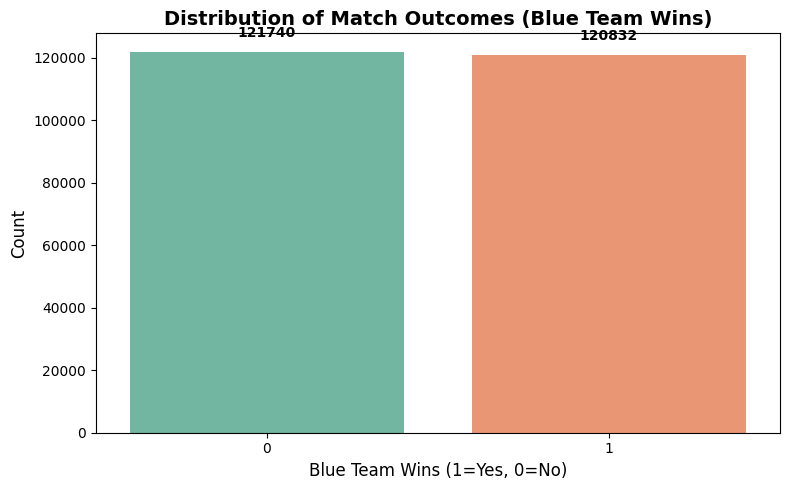

In [9]:
# Distribution of target variable (hasWon)
print("TARGET VARIABLE DISTRIBUTION")
print("="*80)
print(df['hasWon'].value_counts())
print("\nPercentage Distribution:")
print(df['hasWon'].value_counts(normalize=True) * 100)

# Visualization of target distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='hasWon', palette='Set2')
plt.title('Distribution of Match Outcomes (Blue Team Wins)', fontsize=14, fontweight='bold')
plt.xlabel('Blue Team Wins (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Count', fontsize=12)
for i, v in enumerate(df['hasWon'].value_counts()):
    plt.text(i, v + 5000, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

### 4.4 Análisis de valors negatius (falta de dades)
En aquesta secció s'analitza la quantitat de valors faltants i la distribució de dades en el dataset.

In [10]:
# Check for missing values
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_values = df.isnull().sum()
print(f"Total Missing Values: {missing_values.sum()}")
print(f"\nMissing Values per Column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found!")
print(f"\nMissing Values Percentage:")
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage[missing_percentage > 0] if missing_percentage.sum() > 0 else "No missing values found!")

MISSING VALUES ANALYSIS
Total Missing Values: 0

Missing Values per Column:
No missing values found!

Missing Values Percentage:
No missing values found!


### 4.5 Análisis de la correlació entre variables
En aquesta secció s'analitza la correlació entre les variables numèriques i la variable objectiu.

CORRELATION WITH TARGET VARIABLE (hasWon)
hasWon                     1.000000
goldDiff                   0.607487
champLevelDiff             0.580956
expDiff                    0.575538
destroyedBotInnerTurret    0.227670
kills                      0.219807
destroyedBotNexusTurret    0.204864
destroyedBotOuterTurret    0.197713
isFirstTower               0.196205
killedFireDrake            0.181943
destroyedMidOuterTurret    0.179698
killedEarthDrake           0.178618
killedWaterDrake           0.178357
destroyedMidInnerTurret    0.178098
destroyedBotInhibitor      0.175975
assists                    0.167988
killedRiftHerald           0.167418
killedBaronNashor          0.165918
destroyedTopInnerTurret    0.155761
destroyedBotBaseTurret     0.154321
destroyedTopOuterTurret    0.151454
killedAirDrake             0.150468
destroyedMidNexusTurret    0.127401
destroyedMidInhibitor      0.114281
destroyedTopNexusTurret    0.108622
destroyedTopInhibitor      0.091218
killedElderDrake      

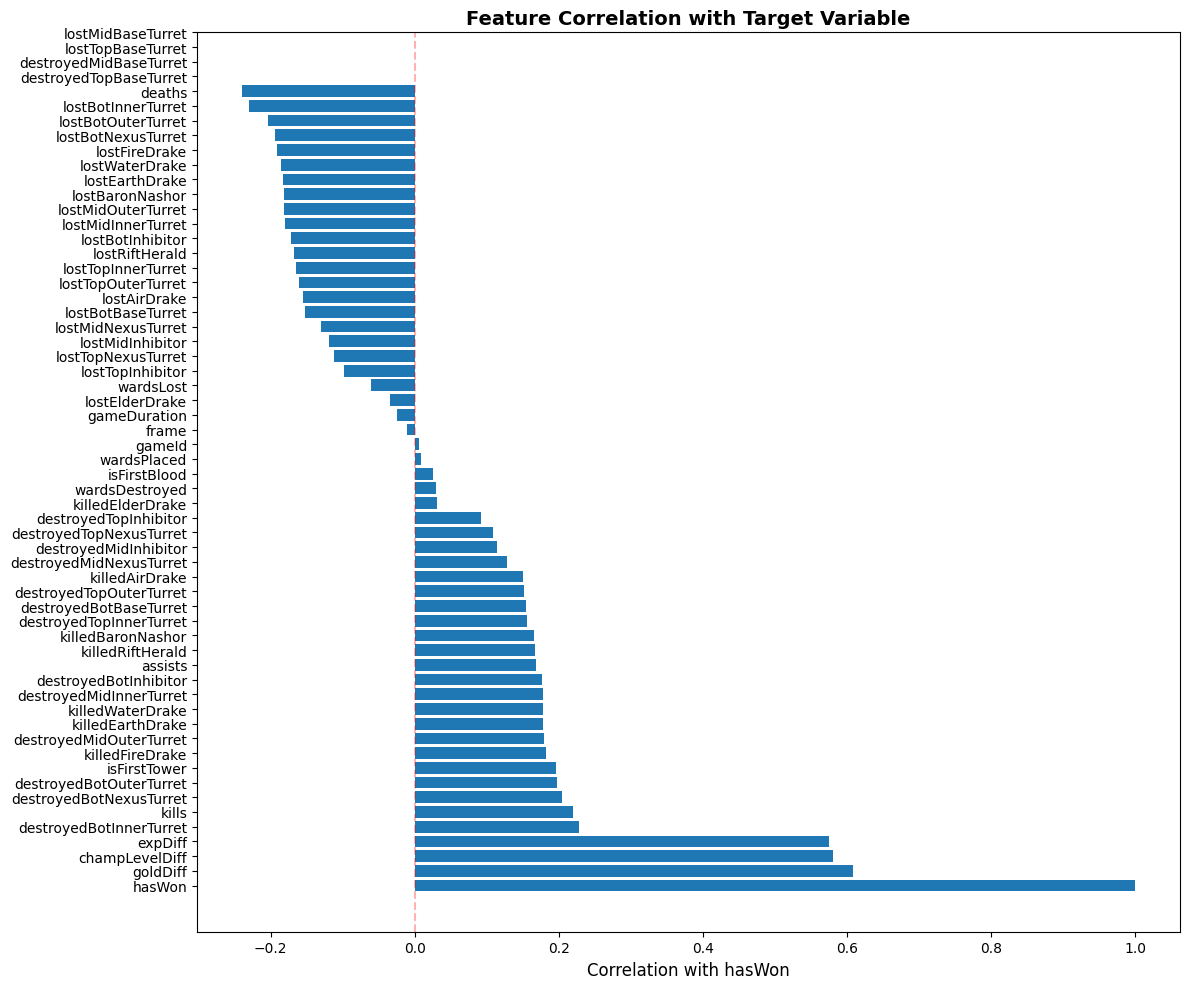

In [11]:
# Calculate correlation with target variable
print("CORRELATION WITH TARGET VARIABLE (hasWon)")
print("="*80)
correlation_with_target = df.corr()['hasWon'].sort_values(ascending=False)
print(correlation_with_target)

# Visualization of correlation with target
plt.figure(figsize=(12, 10))
plt.barh(range(len(correlation_with_target)), correlation_with_target.values)
plt.yticks(range(len(correlation_with_target)), correlation_with_target.index)
plt.xlabel('Correlation with hasWon', fontsize=12)
plt.title('Feature Correlation with Target Variable', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.6 Heatmap de correlació entre variables
Visualització de la matriu de correlació per identificar relacions entre variables.

CORRELATION HEATMAP ANALYSIS


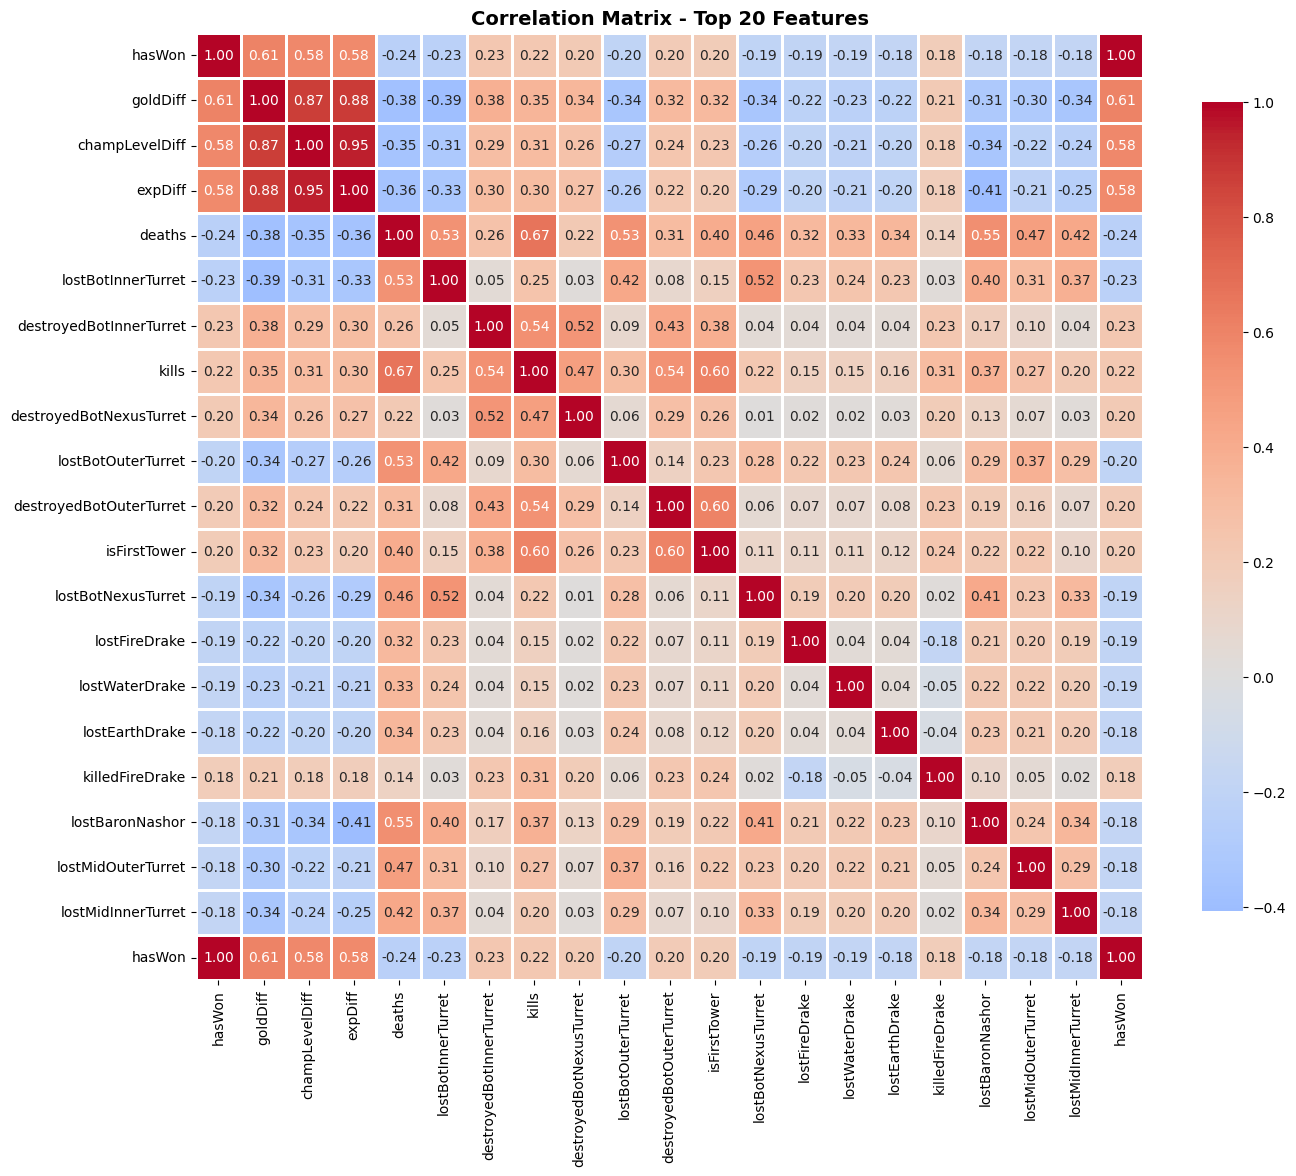

In [12]:
# Create correlation heatmap for top features
print("CORRELATION HEATMAP ANALYSIS")
print("="*80)

# Select top 20 features by correlation with target
top_features = correlation_with_target.abs().nlargest(20).index.tolist()
top_features.append('hasWon')

correlation_matrix = df[top_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Top 20 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.7 Análisis per trams temporals (frames)
Analitzem com les estadístiques canvien al llarg del joc.

GAME DURATION AND FRAME DISTRIBUTION
Total unique games: 24912
Total game records: 242572
Average records per game: 9.74

Game Duration Statistics (milliseconds):
count    2.425720e+05
mean     1.785494e+06
std      3.761901e+05
min      5.490000e+05
25%      1.532000e+06
50%      1.774000e+06
75%      2.025000e+06
max      3.428000e+06
Name: gameDuration, dtype: float64

Frame distribution:
frame
10    24912
12    24842
14    24716
16    24502
18    23430
20    22632
22    20951
24    18818
26    16086
28    12985
30     9937
32     7101
34     4749
36     2985
38     1838
40     1013
42      557
44      283
46      132
48       62
50       25
52        9
54        4
56        3
Name: count, dtype: int64


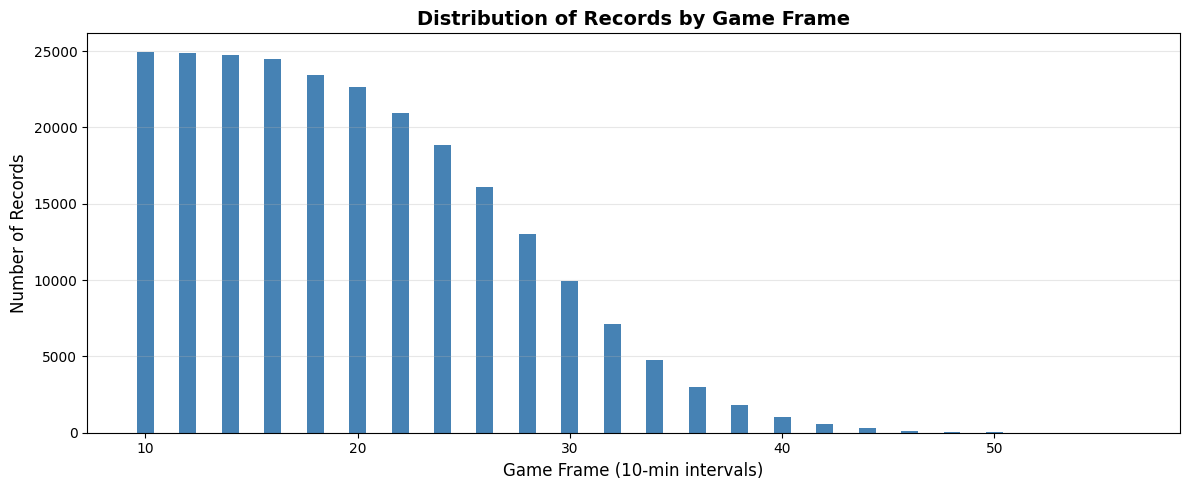

In [13]:
# Analyze temporal distribution
print("GAME DURATION AND FRAME DISTRIBUTION")
print("="*80)
print(f"Total unique games: {df['gameId'].nunique()}")
print(f"Total game records: {len(df)}")
print(f"Average records per game: {len(df) / df['gameId'].nunique():.2f}")
print(f"\nGame Duration Statistics (milliseconds):")
print(df['gameDuration'].describe())
print(f"\nFrame distribution:")
print(df['frame'].value_counts().sort_index())

# Visualization of frames
plt.figure(figsize=(12, 5))
frame_counts = df['frame'].value_counts().sort_index()
plt.bar(frame_counts.index, frame_counts.values, color='steelblue')
plt.xlabel('Game Frame (10-min intervals)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.title('Distribution of Records by Game Frame', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.8 Evolució de les estadístiques de joc per frame
Analitzem com els indicadors econòmics i de nivell canvien durant la partida.

EVOLUTION OF KEY METRICS BY GAME FRAME
Mean statistics by frame and win status:
    frame  hasWon     goldDiff      expDiff  champLevelDiff      kills  \
0      10       0 -1153.235109  -923.141195       -0.211574   4.922493   
1      10       1  1215.184066   859.972247        0.196156   6.781243   
2      12       0 -1722.137384 -1374.511948       -0.285330   6.573026   
3      12       1  1816.679363  1288.133632        0.267296   9.100744   
4      14       0 -2392.247742 -1868.422016       -0.351818   8.301684   
5      14       1  2518.439920  1733.852394        0.331332  11.609980   
6      16       0 -3069.257609 -2468.302814       -0.432012  10.025515   
7      16       1  3219.743767  2310.111102        0.409453  14.158532   
8      18       0 -3469.556060 -2842.446938       -0.462116  11.928308   
9      18       1  3602.460230  2616.652914        0.432463  16.653084   
10     20       0 -3905.727949 -3276.726001       -0.504924  13.819607   
11     20       1  4050.362875  

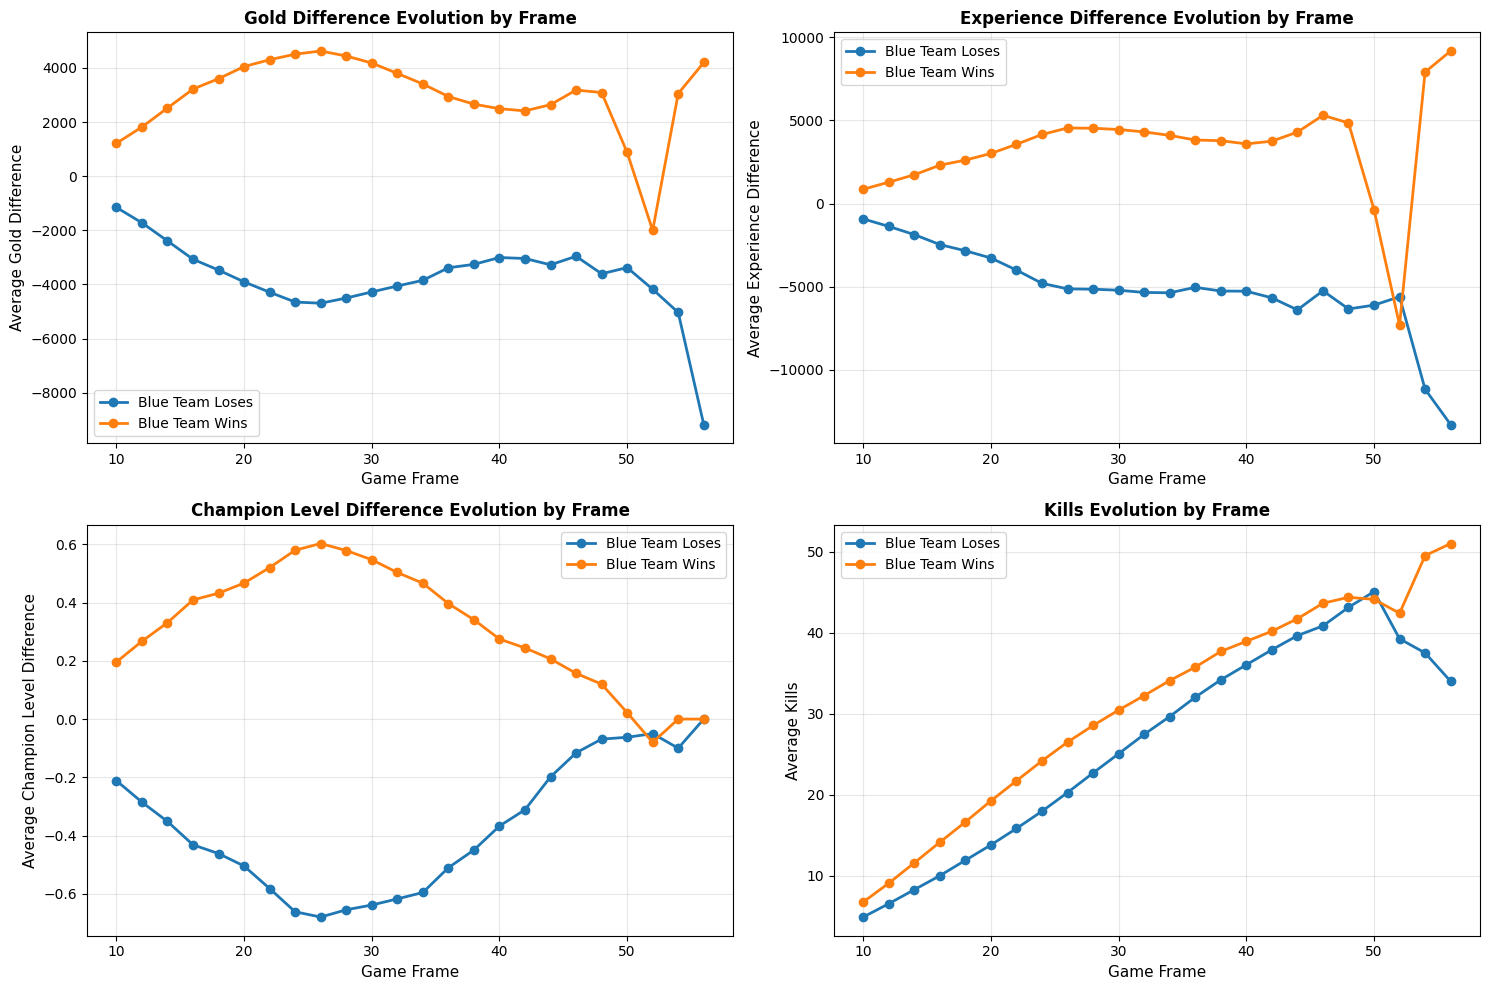

In [14]:
# Analyze evolution of key statistics by frame for winning vs losing
print("EVOLUTION OF KEY METRICS BY GAME FRAME")
print("="*80)

# Group by frame and calculate mean values for winning and losing teams
frame_stats = df.groupby(['frame', 'hasWon']).agg({
    'goldDiff': 'mean',
    'expDiff': 'mean',
    'champLevelDiff': 'mean',
    'kills': 'mean',
    'deaths': 'mean'
}).reset_index()

print("Mean statistics by frame and win status:")
print(frame_stats.head(20))

# Visualization of evolution over frames
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gold difference evolution
ax = axes[0, 0]
for won_status in [0, 1]:
    data = frame_stats[frame_stats['hasWon'] == won_status]
    label = 'Blue Team Wins' if won_status == 1 else 'Blue Team Loses'
    ax.plot(data['frame'], data['goldDiff'], marker='o', label=label, linewidth=2)
ax.set_xlabel('Game Frame', fontsize=11)
ax.set_ylabel('Average Gold Difference', fontsize=11)
ax.set_title('Gold Difference Evolution by Frame', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Experience difference evolution
ax = axes[0, 1]
for won_status in [0, 1]:
    data = frame_stats[frame_stats['hasWon'] == won_status]
    label = 'Blue Team Wins' if won_status == 1 else 'Blue Team Loses'
    ax.plot(data['frame'], data['expDiff'], marker='o', label=label, linewidth=2)
ax.set_xlabel('Game Frame', fontsize=11)
ax.set_ylabel('Average Experience Difference', fontsize=11)
ax.set_title('Experience Difference Evolution by Frame', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Champion level difference evolution
ax = axes[1, 0]
for won_status in [0, 1]:
    data = frame_stats[frame_stats['hasWon'] == won_status]
    label = 'Blue Team Wins' if won_status == 1 else 'Blue Team Loses'
    ax.plot(data['frame'], data['champLevelDiff'], marker='o', label=label, linewidth=2)
ax.set_xlabel('Game Frame', fontsize=11)
ax.set_ylabel('Average Champion Level Difference', fontsize=11)
ax.set_title('Champion Level Difference Evolution by Frame', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Kills evolution
ax = axes[1, 1]
for won_status in [0, 1]:
    data = frame_stats[frame_stats['hasWon'] == won_status]
    label = 'Blue Team Wins' if won_status == 1 else 'Blue Team Loses'
    ax.plot(data['frame'], data['kills'], marker='o', label=label, linewidth=2)
ax.set_xlabel('Game Frame', fontsize=11)
ax.set_ylabel('Average Kills', fontsize=11)
ax.set_title('Kills Evolution by Frame', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.9 Análisis d'objectius épics (Dragons, Baron Nashor, Rift Herald)
Analitzem la importància de la captura dels monstres épics en la victòria.

EPIC OBJECTIVES ANALYSIS
Average objective metrics by win status:
        killedFireDrake  killedWaterDrake  killedAirDrake  killedEarthDrake  \
hasWon                                                                        
0                0.2035            0.2086          0.2246            0.2111   
1                0.3890            0.3926          0.3799            0.3968   

        killedElderDrake  lostFireDrake  lostWaterDrake  lostAirDrake  \
hasWon                                                                  
0                 0.0031         0.4074          0.4109        0.3963   
1                 0.0080         0.2089          0.2162        0.2334   

        lostEarthDrake  lostElderDrake  killedBaronNashor  lostBaronNashor  \
hasWon                                                                       
0               0.4164          0.0085             0.0771           0.2329   
1               0.2225          0.0029             0.2060           0.0831   

        kil

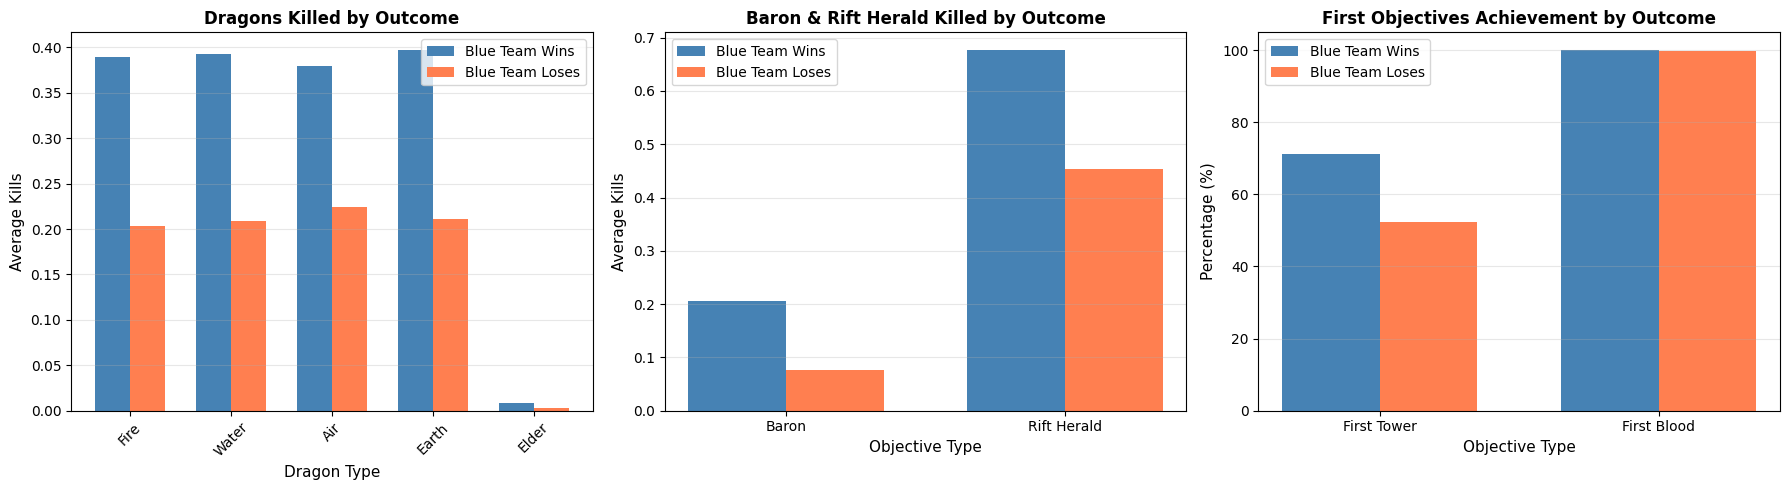

In [15]:
# Analyze epic objectives
print("EPIC OBJECTIVES ANALYSIS")
print("="*80)

# Dragons killed and lost
dragons_data = df.groupby('hasWon').agg({
    'killedFireDrake': 'mean',
    'killedWaterDrake': 'mean',
    'killedAirDrake': 'mean',
    'killedEarthDrake': 'mean',
    'killedElderDrake': 'mean',
    'lostFireDrake': 'mean',
    'lostWaterDrake': 'mean',
    'lostAirDrake': 'mean',
    'lostEarthDrake': 'mean',
    'lostElderDrake': 'mean',
    'killedBaronNashor': 'mean',
    'lostBaronNashor': 'mean',
    'killedRiftHerald': 'mean',
    'lostRiftHerald': 'mean',
}).round(4)

print("Average objective metrics by win status:")
print(dragons_data)

# Visualization of objectives
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dragons
ax = axes[0]
dragon_types = ['Fire', 'Water', 'Air', 'Earth', 'Elder']
wins = [df[df['hasWon']==1]['killedFireDrake'].mean(),
        df[df['hasWon']==1]['killedWaterDrake'].mean(),
        df[df['hasWon']==1]['killedAirDrake'].mean(),
        df[df['hasWon']==1]['killedEarthDrake'].mean(),
        df[df['hasWon']==1]['killedElderDrake'].mean()]
losses = [df[df['hasWon']==0]['killedFireDrake'].mean(),
          df[df['hasWon']==0]['killedWaterDrake'].mean(),
          df[df['hasWon']==0]['killedAirDrake'].mean(),
          df[df['hasWon']==0]['killedEarthDrake'].mean(),
          df[df['hasWon']==0]['killedElderDrake'].mean()]

x = np.arange(len(dragon_types))
width = 0.35
ax.bar(x - width/2, wins, width, label='Blue Team Wins', color='steelblue')
ax.bar(x + width/2, losses, width, label='Blue Team Loses', color='coral')
ax.set_xlabel('Dragon Type', fontsize=11)
ax.set_ylabel('Average Kills', fontsize=11)
ax.set_title('Dragons Killed by Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dragon_types, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Baron and Rift Herald
ax = axes[1]
objectives = ['Baron', 'Rift Herald']
wins_obj = [df[df['hasWon']==1]['killedBaronNashor'].mean(),
            df[df['hasWon']==1]['killedRiftHerald'].mean()]
losses_obj = [df[df['hasWon']==0]['killedBaronNashor'].mean(),
              df[df['hasWon']==0]['killedRiftHerald'].mean()]

x = np.arange(len(objectives))
ax.bar(x - width/2, wins_obj, width, label='Blue Team Wins', color='steelblue')
ax.bar(x + width/2, losses_obj, width, label='Blue Team Loses', color='coral')
ax.set_xlabel('Objective Type', fontsize=11)
ax.set_ylabel('Average Kills', fontsize=11)
ax.set_title('Baron & Rift Herald Killed by Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(objectives)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# First objectives
ax = axes[2]
first_objs = ['First Tower', 'First Blood']
wins_first = [df[df['hasWon']==1]['isFirstTower'].mean() * 100,
              df[df['hasWon']==1]['isFirstBlood'].mean() * 100]
losses_first = [df[df['hasWon']==0]['isFirstTower'].mean() * 100,
                df[df['hasWon']==0]['isFirstBlood'].mean() * 100]

x = np.arange(len(first_objs))
ax.bar(x - width/2, wins_first, width, label='Blue Team Wins', color='steelblue')
ax.bar(x + width/2, losses_first, width, label='Blue Team Loses', color='coral')
ax.set_xlabel('Objective Type', fontsize=11)
ax.set_ylabel('Percentage (%)', fontsize=11)
ax.set_title('First Objectives Achievement by Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(first_objs)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.10 Análisis de destrucció d'estructures (Torres i Inhibidors)
Analitzem la relació entre destrucció d'estructures defensives i la victòria.

TOWER AND INHIBITOR DESTRUCTION ANALYSIS
Average tower/inhibitor destruction metrics by win status:
        destroyedTopInhibitor  destroyedMidInhibitor  destroyedBotInhibitor  \
hasWon                                                                        
0                      0.0079                 0.0096                 0.0328   
1                      0.0361                 0.0507                 0.1430   

        destroyedTopNexusTurret  destroyedMidNexusTurret  \
hasWon                                                     
0                        0.0131                   0.0143   
1                        0.0514                   0.0634   

        destroyedBotNexusTurret  destroyedTopBaseTurret  \
hasWon                                                    
0                        0.0400                     0.0   
1                        0.1638                     0.0   

        destroyedMidBaseTurret  destroyedBotBaseTurret  \
hasWon                                         

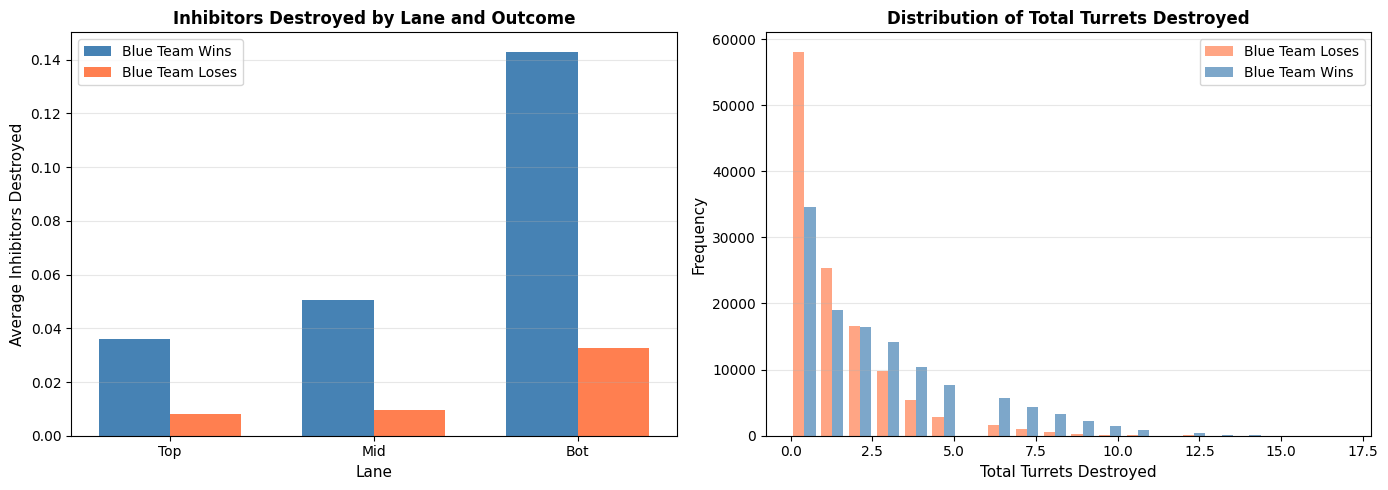

In [16]:
# Analyze tower and inhibitor destruction
print("TOWER AND INHIBITOR DESTRUCTION ANALYSIS")
print("="*80)

tower_inhibitor_stats = df.groupby('hasWon').agg({
    'destroyedTopInhibitor': 'mean',
    'destroyedMidInhibitor': 'mean',
    'destroyedBotInhibitor': 'mean',
    'destroyedTopNexusTurret': 'mean',
    'destroyedMidNexusTurret': 'mean',
    'destroyedBotNexusTurret': 'mean',
    'destroyedTopBaseTurret': 'mean',
    'destroyedMidBaseTurret': 'mean',
    'destroyedBotBaseTurret': 'mean',
    'destroyedTopInnerTurret': 'mean',
    'destroyedMidInnerTurret': 'mean',
    'destroyedBotInnerTurret': 'mean',
    'destroyedTopOuterTurret': 'mean',
    'destroyedMidOuterTurret': 'mean',
    'destroyedBotOuterTurret': 'mean',
}).round(4)

print("Average tower/inhibitor destruction metrics by win status:")
print(tower_inhibitor_stats)

# Calculate total structures destroyed
df['totalTurretsDestroyed'] = (df['destroyedTopInhibitor'] + df['destroyedMidInhibitor'] + 
                               df['destroyedBotInhibitor'] + df['destroyedTopNexusTurret'] + 
                               df['destroyedMidNexusTurret'] + df['destroyedBotNexusTurret'] +
                               df['destroyedTopBaseTurret'] + df['destroyedMidBaseTurret'] + 
                               df['destroyedBotBaseTurret'] + df['destroyedTopInnerTurret'] + 
                               df['destroyedMidInnerTurret'] + df['destroyedBotInnerTurret'] +
                               df['destroyedTopOuterTurret'] + df['destroyedMidOuterTurret'] + 
                               df['destroyedBotOuterTurret'])

df['totalInhibitorsDestroyed'] = (df['destroyedTopInhibitor'] + df['destroyedMidInhibitor'] + 
                                   df['destroyedBotInhibitor'])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inhibitors by lane
ax = axes[0]
lanes = ['Top', 'Mid', 'Bot']
wins_inh = [df[df['hasWon']==1]['destroyedTopInhibitor'].mean(),
            df[df['hasWon']==1]['destroyedMidInhibitor'].mean(),
            df[df['hasWon']==1]['destroyedBotInhibitor'].mean()]
losses_inh = [df[df['hasWon']==0]['destroyedTopInhibitor'].mean(),
              df[df['hasWon']==0]['destroyedMidInhibitor'].mean(),
              df[df['hasWon']==0]['destroyedBotInhibitor'].mean()]

x = np.arange(len(lanes))
width = 0.35
ax.bar(x - width/2, wins_inh, width, label='Blue Team Wins', color='steelblue')
ax.bar(x + width/2, losses_inh, width, label='Blue Team Loses', color='coral')
ax.set_xlabel('Lane', fontsize=11)
ax.set_ylabel('Average Inhibitors Destroyed', fontsize=11)
ax.set_title('Inhibitors Destroyed by Lane and Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(lanes)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Total structures destroyed distribution
ax = axes[1]
wins_data = df[df['hasWon']==1]['totalTurretsDestroyed']
losses_data = df[df['hasWon']==0]['totalTurretsDestroyed']

ax.hist([losses_data, wins_data], bins=20, label=['Blue Team Loses', 'Blue Team Wins'], 
        color=['coral', 'steelblue'], alpha=0.7)
ax.set_xlabel('Total Turrets Destroyed', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Total Turrets Destroyed', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.11 Análisis de Visió (Wards)
Analitzem la importància del control de visió en la partida.

WARD VISION CONTROL ANALYSIS
Ward statistics by win status:
       wardsPlaced                    wardsDestroyed                   \
              mean      std min   max           mean     std min  max   
hasWon                                                                  
0          56.2893  57.9750   3  1014        10.2311  8.6444   0  102   
1          57.3819  59.4856   4   945        10.7449  8.7751   0  115   

       wardsLost                   
            mean     std min  max  
hasWon                             
0        10.7926  8.9677   0  107  
1         9.7296  8.4634   0  102  


C:\Users\heinz\AppData\Local\Temp\ipykernel_21288\978417966.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([losses_placed, wins_placed], labels=['Loses', 'Wins'])
C:\Users\heinz\AppData\Local\Temp\ipykernel_21288\978417966.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([losses_destroyed, wins_destroyed], labels=['Loses', 'Wins'])
C:\Users\heinz\AppData\Local\Temp\ipykernel_21288\978417966.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([losses_lost, wins_lost], labels=['Loses', 'Wins'])


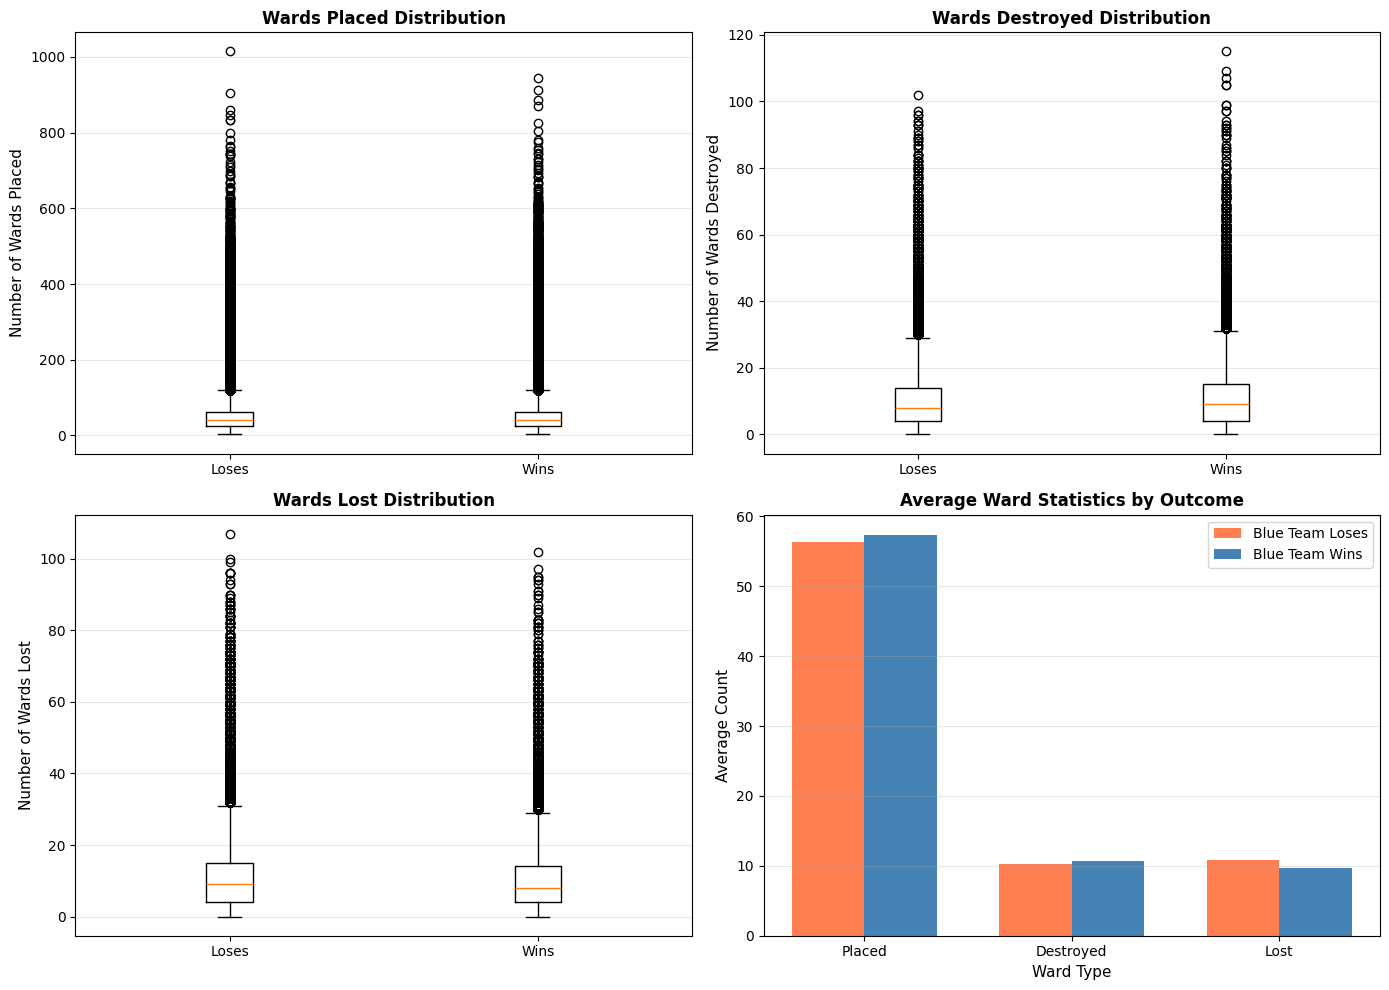

In [17]:
# Analyze ward vision control
print("WARD VISION CONTROL ANALYSIS")
print("="*80)

wards_stats = df.groupby('hasWon').agg({
    'wardsPlaced': ['mean', 'std', 'min', 'max'],
    'wardsDestroyed': ['mean', 'std', 'min', 'max'],
    'wardsLost': ['mean', 'std', 'min', 'max'],
}).round(4)

print("Ward statistics by win status:")
print(wards_stats)

# Create ward efficiency metric
df['wardEfficiency'] = df['wardsDestroyed'] / (df['wardsPlaced'] + 1)  # +1 to avoid division by zero

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Wards placed
ax = axes[0, 0]
wins_placed = df[df['hasWon']==1]['wardsPlaced']
losses_placed = df[df['hasWon']==0]['wardsPlaced']
ax.boxplot([losses_placed, wins_placed], labels=['Loses', 'Wins'])
ax.set_ylabel('Number of Wards Placed', fontsize=11)
ax.set_title('Wards Placed Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Wards destroyed
ax = axes[0, 1]
wins_destroyed = df[df['hasWon']==1]['wardsDestroyed']
losses_destroyed = df[df['hasWon']==0]['wardsDestroyed']
ax.boxplot([losses_destroyed, wins_destroyed], labels=['Loses', 'Wins'])
ax.set_ylabel('Number of Wards Destroyed', fontsize=11)
ax.set_title('Wards Destroyed Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Wards lost
ax = axes[1, 0]
wins_lost = df[df['hasWon']==1]['wardsLost']
losses_lost = df[df['hasWon']==0]['wardsLost']
ax.boxplot([losses_lost, wins_lost], labels=['Loses', 'Wins'])
ax.set_ylabel('Number of Wards Lost', fontsize=11)
ax.set_title('Wards Lost Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Vision control advantage (placed - destroyed ratio)
ax = axes[1, 1]
wins_mean = [df[df['hasWon']==1]['wardsPlaced'].mean(),
             df[df['hasWon']==1]['wardsDestroyed'].mean(),
             df[df['hasWon']==1]['wardsLost'].mean()]
losses_mean = [df[df['hasWon']==0]['wardsPlaced'].mean(),
               df[df['hasWon']==0]['wardsDestroyed'].mean(),
               df[df['hasWon']==0]['wardsLost'].mean()]

x = np.arange(3)
width = 0.35
ax.bar(x - width/2, losses_mean, width, label='Blue Team Loses', color='coral')
ax.bar(x + width/2, wins_mean, width, label='Blue Team Wins', color='steelblue')
ax.set_xlabel('Ward Type', fontsize=11)
ax.set_ylabel('Average Count', fontsize=11)
ax.set_title('Average Ward Statistics by Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Placed', 'Destroyed', 'Lost'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()